# Задача № 11

Повторить график выбора модели по Evidence с реальными экспериментами. График взять из презентации (слайд 15, "Cхема выбора модели"). Выборка: произвольная (допускается использование синтетических выборок или использование одного наиболее значимого параметра на одном из стандартных датасетов sklearn). Модель: набор моделей, соответствующих полиномаильной регрессии (сложность модели будет соответствовать степени полинома) или однослойная нейросеть (сложность будет соответствовать количеству нейронов на скрытом слое). Априорное распределение параметров: нормальное распределение со скалярным параметром дисперсии дисперсией $(\mathcal{N}(\mathbf{0}, \sigma^2 \mathrm{I}))$. Оптимизацию $\sigma$ провести итеративным методом с использованием аппроксимации Лапласа.

### Задача № 11

* Повторить график выбора модели по Evidence с реальными экспериментами. 
* График взять из презентации (слайд 15, "Cхема выбора модели"). 
* Выборка: произвольная 
* Модель: набор моделей, соответствующих полиномаильной регрессии 
* Априорное распределение параметров: нормальное распределение со скалярным параметром дисперсии дисперсией $(\mathcal{N}(\mathbf{0}, \sigma^2 \mathrm{I}))$. Оптимизацию $\sigma$ провести итеративным методом с использованием аппроксимации Лапласа.

## Обоснованность для линейной регрессии:

$ \mathbf{y} = \mathbf{Xw} + \varepsilon, \mathbf{w} \sim \mathcal{N}(\mathbf{0}, \sigma_w^2\mathbf{I}), \varepsilon \sim \mathcal{N}(\mathbf{0}, \sigma_{\varepsilon}^2\mathbf{I})$

Совместное правдоподобие: $p(\mathbf{y}, \mathbf{w}|\mathbf{X}, \sigma_w^2, \sigma_{\varepsilon}^2) = p(\mathbf{y}|\mathbf{X}, \mathbf{w}, \sigma_{\varepsilon}^2)p(\mathbf{w}|\sigma_w^2).$

Обоснованность:

$p(\mathbf{y}|\mathbf{X}, \sigma_w^2, \sigma_{\varepsilon}^2) = \int p(\mathbf{y}, \mathbf{w}|\mathbf{X}, \sigma_w^2, \sigma_{\varepsilon}^2) d\mathbf{w} = \int p(\mathbf{y}|\mathbf{X}, \mathbf{w}, \sigma_{\varepsilon}^2)p(\mathbf{w}|\sigma_w^2).$

$\mathbf{y}|\mathbf{X}, \sigma_w^2, \sigma_{\varepsilon}^2 \sim \mathcal{N}(\mathbf{0}, \sigma_{\varepsilon}^2 \mathbf{I} + \sigma_w^2 \mathbf{X X^T})$

Поэтому:

$ \log p(\mathbf{y}|\mathbf{X}, \sigma_w^2, \sigma_{\varepsilon}^2) \propto - \frac{1}{2} \log \det\left(\sigma_{\varepsilon}^2 \mathbf{I} + \sigma_w^2 \mathbf{X X^T}\right) - \frac{1}{2} \mathbf{y}^T\left( \sigma_{\varepsilon}^2 \mathbf{I} + \sigma_w^2 \mathbf{X X^T}\right)^{-1} \mathbf{y}$

In [211]:
x = np.random.uniform(-2 * np.pi/3, 2 * np.pi/3, 100).reshape(-1, 1)
ys = {'Polynom^0':np.ones(x.shape[0]) * np.random.random(1)}
for p in range(1, 8):
    v = np.hstack([x ** i for i in range(p+1)]).dot(np.random.normal(size=p+1))
    v = (v - v.min()) / (v.max() - v.min())
    v+= np.random.normal(0, 0.1, (x.size, ))
    ys[f'Polynom^{p}'] = v
ys['sin'] = np.sin(x) + np.random.normal(0, 0.1, (x.size, 1))

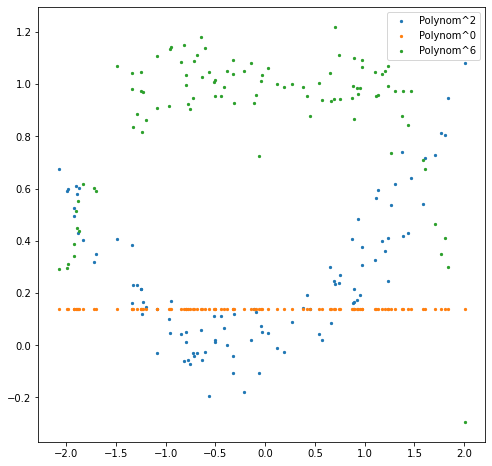

In [227]:
fig = plt.subplots(figsize =(8, 8))
[plt.scatter(x, ys[k], s=5, label=k) for k in np.random.choice(list(ys.keys()), 3)]
plt.legend()

In [213]:
def get_log_evidence(X, y, sw2, se2):
    out = se2 * np.eye(X.shape[0]) + sw2 * X.dot(X.T)
    out = -1/2 * np.log(np.linalg.det(out)) - 1/2 * y.T.dot(np.linalg.inv(out).dot(y))
    return out.item()

In [214]:
def find_sw_by_p(x, y, se2, p, step=0.01):
    x = np.hstack([x ** i for i in range(p + 1)])
    old_value = -1e10
    sw2 = 0
    while True:
        new_value = get_log_evidence(x, y, sw2, se2) 
        if new_value < old_value:
            return sw2, old_value
        old_value = max(old_value, new_value)
        sw2 += step

In [215]:
s = {}
log_evidences = {}
for k in tqdm(ys.keys()):
    s[k] = {}
    log_evidences[k] = {}
    for p in range(8):
        s[k][p], log_evidences[k][p] = find_sw_by_p(x, ys[k], se2, p, step=0.01)

  0%|          | 0/9 [00:00<?, ?it/s]

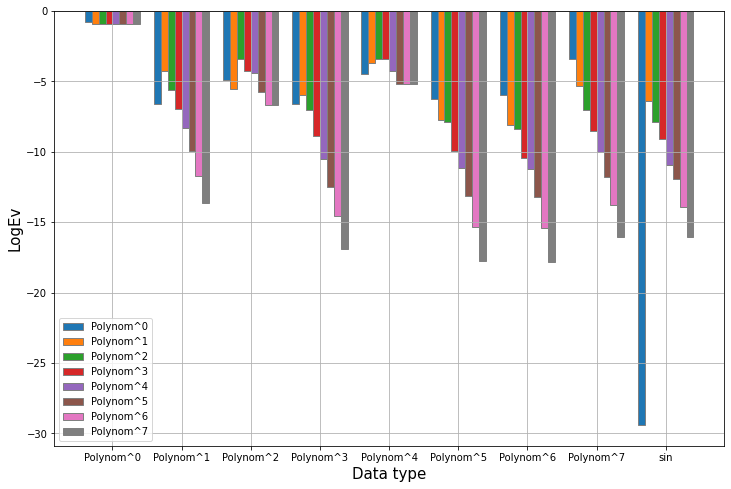

In [223]:
# set width of bar
barWidth = 0.1
fig = plt.subplots(figsize =(12, 8))

# Set position of bar on X axis
br = np.arange(len(log_evidences))

plt.grid()
for p in range(8):
    h = [log_evidences[k][p] for k in log_evidences.keys()]
    plt.bar(br + barWidth * p, h, width = barWidth,
            edgecolor ='grey', label = f'Polynom^{p}')

# Adding Xticks
plt.xlabel('Data type', fontsize = 15)
plt.ylabel('LogEv', fontsize = 15)
plt.xticks(br + barWidth*3.5, log_evidences.keys())

plt.legend()
plt.show()